Import required libraries

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
from math import sqrt
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error

In [ ]:
import os 
  
# current directory 
current_dir = os.getcwd() 
relative_path=os.path.abspath(os.path.join(current_dir, os.pardir))

Read data

In [53]:
df = pd.read_csv(
    relative_path+"\\age_structure_data\\WPP2022_Demographic_Indicators_Medium.csv")

Filter data, set index in datetime 

In [54]:
df = df.loc[(df.Location == 'Malaysia') & (df.Time < 2010)&(df.Time > 1963), [
    'Time','CBR', 'CDR', 'CNMR']]
df['Year'] = pd.to_datetime(df['Time'], format='%Y')
df = df.set_index("Year")


In [55]:
df

,Time,CBR,CDR,CNMR
Year,,,,
1964-01-01,1964,38.954,8.794,-1.208
1965-01-01,1965,37.647,8.257,-1.446
1966-01-01,1966,36.323,7.970,-2.232
1967-01-01,1967,35.037,7.707,-2.369
1968-01-01,1968,34.414,7.493,-2.620
1969-01-01,1969,33.931,7.281,-2.658
1970-01-01,1970,33.561,7.078,-2.464
1971-01-01,1971,33.110,6.880,-3.129
1972-01-01,1972,32.769,6.684,-2.612


In [56]:
df_birth = df.loc[:, ['CBR']]
df_death = df.loc[:, ['CDR']]
df_migration = df.loc[:, ['CNMR']]


Stationary Check

In [57]:
def stationary_test(df):
    window_mean = df.rolling(window=10).mean()
    window_standard_deviation = df.rolling(window=10).std()
    plt.plot(df, color='black', label='log_ratio')
    plt.plot(window_mean, color='red', label='mean by 10')
    plt.plot(window_standard_deviation, color='blue',
             label='standard deviation by 10')
    plt.legend(loc='best')
    plt.title('Rolling Mean and standard deviation')
    plt.show()

    # Check using adftest
    result = adfuller(df)
    print('p :', result[1])  # if p<0.05 and
    # adf lower than critical values, reject null hypotheses, stationary
    print('adf statistic :', result[0])
    print('critical value :')
    for key, value in result[4].items():
        print(key, value)

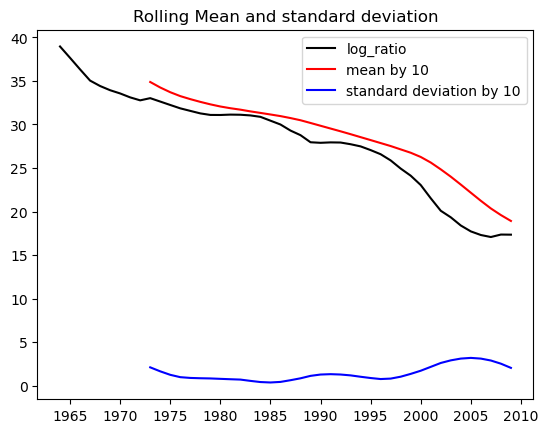

p : 0.9350055567508325
adf statistic : -0.22875990430001025
critical value :
1% -3.5885733964124715
5% -2.929885661157025
10% -2.6031845661157025


In [58]:
df_birth.dropna(inplace=True)
stationary_test(df_birth)

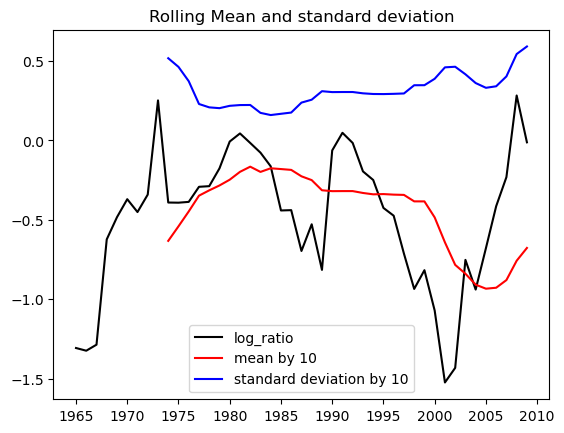

p : 0.09761297212253811
adf statistic : -2.5780793909216064
critical value :
1% -3.5885733964124715
5% -2.929885661157025
10% -2.6031845661157025


In [59]:
df_birth_differenced = df_birth-df_birth.shift()
df_birth_differenced.dropna(inplace=True)
stationary_test(df_birth_differenced)

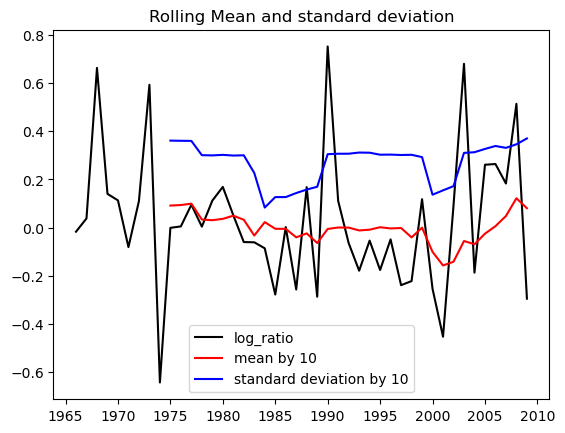

p : 8.119196524275877e-10
adf statistic : -6.9826083998112125
critical value :
1% -3.5925042342183704
5% -2.931549768951162
10% -2.60406594375338


In [60]:
df_birth_differenced2 = df_birth_differenced-df_birth_differenced.shift()
df_birth_differenced2.dropna(inplace=True)
stationary_test(df_birth_differenced2)

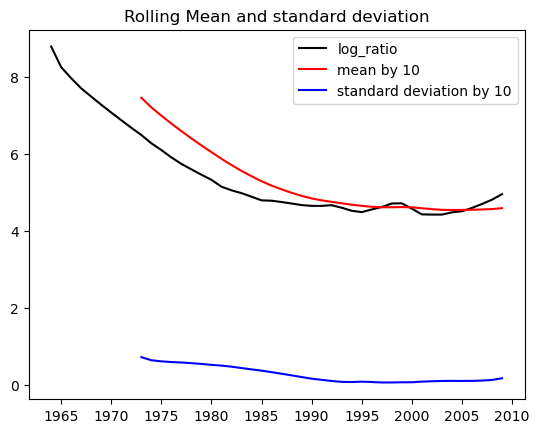

p : 0.21190727020772726
adf statistic : -2.18453199606202
critical value :
1% -3.5885733964124715
5% -2.929885661157025
10% -2.6031845661157025


In [61]:
df_death.dropna(inplace=True)
stationary_test(df_death)

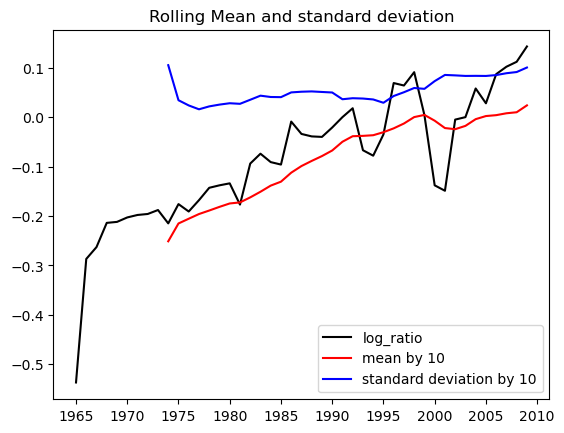

p : 0.008786170189438483
adf statistic : -3.470202038831228
critical value :
1% -3.5885733964124715
5% -2.929885661157025
10% -2.6031845661157025


In [62]:
df_death_differenced = df_death-df_death.shift()
df_death_differenced.dropna(inplace=True)
stationary_test(df_death_differenced)

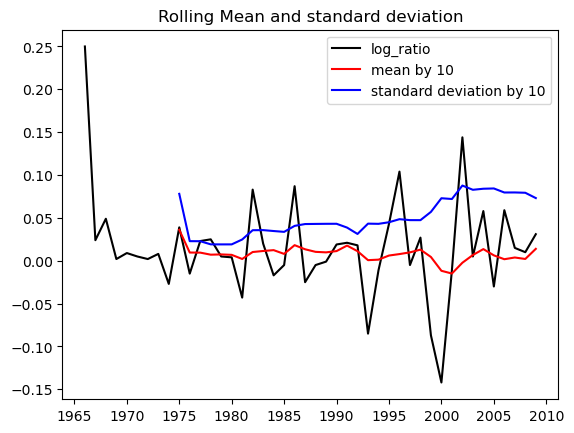

p : 1.1467839396208223e-06
adf statistic : -5.620722387541975
critical value :
1% -3.60098336718852
5% -2.9351348158036012
10% -2.6059629803688282


In [63]:
df_death_differenced2 = df_death_differenced-df_death_differenced.shift()
df_death_differenced2.dropna(inplace=True)
stationary_test(df_death_differenced2)

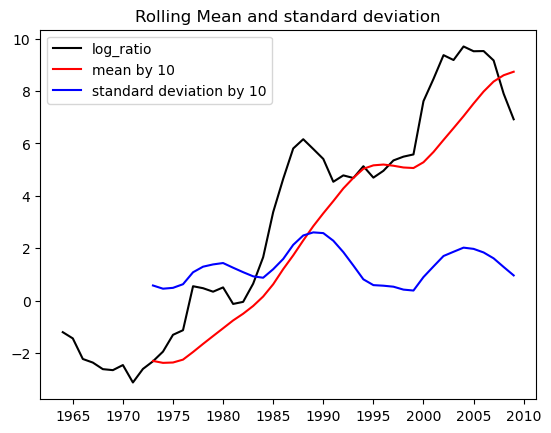

p : 0.6933365825250819
adf statistic : -1.1533457534896798
critical value :
1% -3.5885733964124715
5% -2.929885661157025
10% -2.6031845661157025


In [64]:
df_migration.dropna(inplace=True)
stationary_test(df_migration)

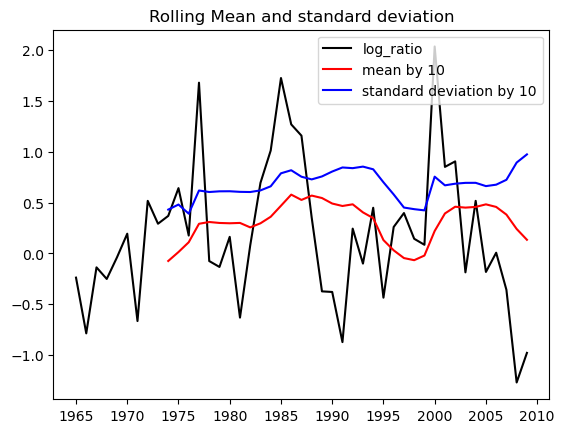

p : 0.0023132632483225004
adf statistic : -3.864372860714913
critical value :
1% -3.5885733964124715
5% -2.929885661157025
10% -2.6031845661157025


In [65]:
df_migration_differenced = df_migration-df_migration.shift()
df_migration_differenced.dropna(inplace=True)
stationary_test(df_migration_differenced)

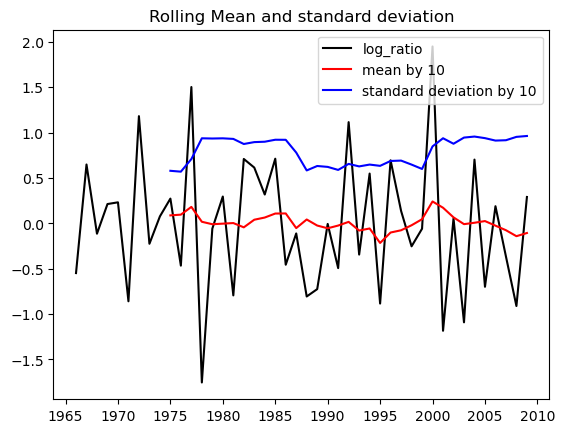

p : 9.329633213337721e-19
adf statistic : -10.527601622092515
critical value :
1% -3.5925042342183704
5% -2.931549768951162
10% -2.60406594375338


In [66]:
df_migration_differenced2 = df_migration_differenced-df_migration_differenced.shift()
df_migration_differenced2.dropna(inplace=True)
stationary_test(df_migration_differenced2)

In [72]:
cv1_train_birth, cv1_test_birth = train_test_split(df_birth, test_size=0.2, shuffle=False)
cv2_train_birth, cv2_test_birth = train_test_split(cv1_train_birth, test_size=0.2, shuffle=False)
cv3_train_birth, cv3_test_birth = train_test_split(cv2_train_birth, test_size=0.15, shuffle=False)

In [73]:
cv1_train_death, cv1_test_death = train_test_split(df_death, test_size=0.2, shuffle=False)
cv2_train_death, cv2_test_death = train_test_split(cv1_train_death, test_size=0.2, shuffle=False)
cv3_train_death, cv3_test_death = train_test_split(cv2_train_death, test_size=0.15, shuffle=False)

In [74]:
cv1_train_migration, cv1_test_migration = train_test_split(df_migration, test_size=0.2, shuffle=False)
cv2_train_migration, cv2_test_migration = train_test_split(cv1_train_migration, test_size=0.2, shuffle=False)
cv3_train_migration, cv3_test_migration = train_test_split(cv2_train_migration, test_size=0.15, shuffle=False)

In [75]:
def find_best_pdq(train_data, test_data):
    df_search = pd.DataFrame()
    for p in range(6):
        for d in range(1, 3):
            for q in range(6):
                arima_model = ARIMA(train_data, order=(p, d, q)).fit()
                # predict from the position of test data which is length of train data
                prediction = arima_model.predict(
                    start=len(train_data), end=len(train_data)+len(test_data)-1)
                rmse = sqrt(mean_squared_error(test_data, prediction))
                df_search = df_search.append({'pdq_paramters': str(
                    p)+" "+str(d)+" "+str(q), 'rmse': rmse}, ignore_index=True)
    return df_search
    #print(df_search.sort_values('rmse', ascending=True).head())
    # print()

In [76]:
df_cv1=find_best_pdq(cv1_train_birth, cv1_test_birth)
df_cv2=find_best_pdq(cv2_train_birth, cv2_test_birth)
df_cv3=find_best_pdq(cv3_train_birth, cv3_test_birth)

concatenated = pd.concat([df_cv1, df_cv2, df_cv3])
concatenated=concatenated.groupby('pdq_paramters').mean()
concatenated.sort_values('rmse', ascending=True)

,rmse
pdq_paramters,
2 2 1,1.146616
0 2 3,1.167703
0 2 1,1.213873
1 2 0,1.236150
1 2 3,1.258815
...,...
0 1 1,2.893266
2 1 4,2.902322
0 1 2,2.902732


In [77]:
df_cv1=find_best_pdq(cv1_train_death, cv1_test_death)
df_cv2=find_best_pdq(cv2_train_death, cv2_test_death)
df_cv3=find_best_pdq(cv3_train_death, cv3_test_death)

concatenated = pd.concat([df_cv1, df_cv2, df_cv3])
concatenated=concatenated.groupby('pdq_paramters').mean()
concatenated.sort_values('rmse', ascending=True)

,rmse
pdq_paramters,
3 1 5,0.124540
0 2 0,0.127650
1 1 0,0.128002
2 1 1,0.130264
1 1 1,0.131504
...,...
5 2 2,0.259463
0 1 4,0.260719
3 2 4,0.280333


In [78]:
df_cv1=find_best_pdq(cv1_train_migration, cv1_test_migration)
df_cv2=find_best_pdq(cv2_train_migration, cv2_test_migration)
df_cv3=find_best_pdq(cv3_train_migration, cv3_test_migration)

concatenated = pd.concat([df_cv1, df_cv2, df_cv3])
concatenated=concatenated.groupby('pdq_paramters').mean()
concatenated.sort_values('rmse', ascending=True)

,rmse
pdq_paramters,
2 1 2,1.127823
4 1 4,1.255679
4 1 5,1.264213
3 1 4,1.277887
3 1 5,1.282552
...,...
1 2 3,4.004022
0 2 2,4.230133
5 2 4,4.254598


In [87]:
birth_arima_model = ARIMA(df_birth, order=(2, 2, 1)).fit()
birth_prediction = birth_arima_model.predict(
    start=len(df_birth), end=len(df_birth)+11)


In [88]:
death_arima_model = ARIMA(df_death, order=(3, 1, 5)).fit()
death_prediction = death_arima_model.predict(
    start=len(df_death), end=len(df_death)+11)

In [89]:
migration_arima_model = ARIMA(df_migration, order=(2, 1, 2)).fit()
migration_prediction = migration_arima_model.predict(
    start=len(df_migration), end=len(df_migration)+11)

In [90]:
birth_prediction = birth_prediction.to_frame()
birth_prediction.rename(columns = {'predicted_mean':'CBR'}, inplace = True)
birth_final = pd.concat([df_birth, birth_prediction])
birth_final.index.name='Year'
death_prediction = death_prediction.to_frame()
death_prediction.rename(columns = {'predicted_mean':'CDR'}, inplace = True)
death_final = pd.concat([df_death, death_prediction])
death_final.index.name='Year'
migration_prediction = migration_prediction.to_frame()
migration_prediction.rename(columns = {'predicted_mean':'CNMR'}, inplace = True)
migration_final = pd.concat([df_migration, migration_prediction])
migration_final.index.name='Year'


<function matplotlib.pyplot.show(close=None, block=None)>

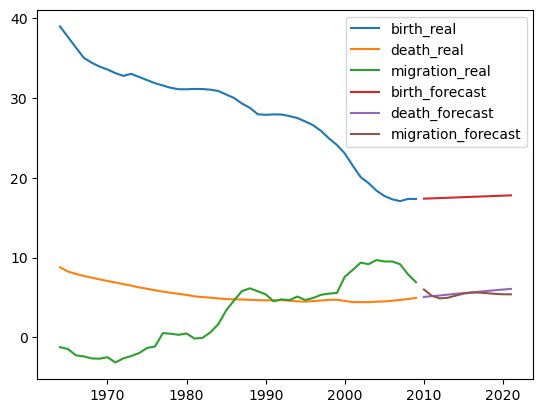

In [91]:
plt.plot(df_birth,label="birth_real")
plt.plot(df_death,label="death_real")
plt.plot(df_migration,label="migration_real")
plt.plot(birth_prediction,label="birth_forecast")
plt.plot(death_prediction,label="death_forecast")
plt.plot(migration_prediction,label="migration_forecast")
plt.legend(loc='best')
plt.show

In [92]:
final = pd.concat([birth_final, death_final, migration_final],axis=1)

In [94]:
final.to_csv(relative_path+"\\age_structure_data\\attributes.csv")